In [1]:
!pip install seaborn xgboost -q

In [2]:
import time
import numpy as np
import tensorflow as tf
import yfinance as yf
import pandas as pd
from tensorflow.keras import layers, Model
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
SEED = 1719
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [6]:
df = pd.read_csv("google_20y.csv")
df.head()

,Date,Price,Close,High,Low,Open
0,2005-06-20,7.131903,7.156032,6.759511,6.867970,840147012
1,2005-06-21,7.160260,7.221455,7.088866,7.165982,604686708
2,2005-06-22,7.196579,7.271704,7.180908,7.205783,418541040
3,2005-06-23,7.206779,7.333646,7.126928,7.164241,561693744
4,2005-06-24,7.394343,7.412999,7.203545,7.236381,710137152


In [7]:
df[['Date', 'Close']].head()

,Date,Close
0,2005-06-20,7.156032
1,2005-06-21,7.221455
2,2005-06-22,7.271704
3,2005-06-23,7.333646
4,2005-06-24,7.412999


In [8]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

There are 5032 number of days in the dataset.


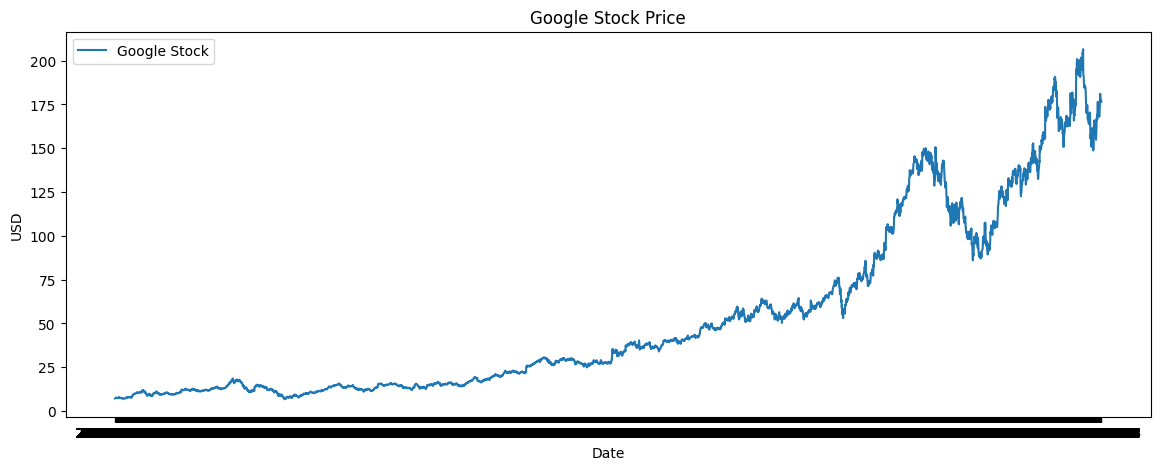

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['Close'], label='Google Stock')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Google Stock Price')
plt.legend()
plt.show()

In [10]:
num_training_days = int(df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    df.shape[0]-num_training_days))

Number of training days: 3522. Number of test days: 1510.


In [11]:
total_df = df[['Date', 'Close']].copy()

In [12]:
total_df['pct_change'] = (df['Close'] - df['Close'].shift(1))/ df['Close'].shift(1)
total_df['log_change'] = np.log(df['Close']/ df['Close'].shift(1))

In [13]:

def get_technical_indicators(dataset):
    """
    Calculate comprehensive technical indicators for financial data
    """
    dataset = dataset.copy()

    # Helper function for EMA calculation
    def calculate_ema(data, period):
        multiplier = 2 / (period + 1)
        ema = [data.iloc[0]]  # Start with first value
        for i in range(1, len(data)):
            ema.append((data.iloc[i] * multiplier) + (ema[i-1] * (1 - multiplier)))
        return pd.Series(ema, index=data.index)

    # Helper function for RSI calculation
    def calculate_rsi(data, period):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    # Helper function for ATR calculation
    def calculate_atr(high, low, close, period):
        prev_close = close.shift(1)
        tr1 = high - low
        tr2 = abs(high - prev_close)
        tr3 = abs(low - prev_close)

        true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr

    # Helper function for Bollinger Bands
    def calculate_bollinger_bands(data, period):
        sma = data.rolling(window=period).mean()
        std = data.rolling(window=period).std()
        upper_band = sma + (std * 2)
        lower_band = sma - (std * 2)
        return upper_band, lower_band

    # Helper function for RSV (Raw Stochastic Value)
    def calculate_rsv(data, period):
        lowest_low = data.rolling(window=period).min()
        highest_high = data.rolling(window=period).max()
        rsv = ((data - lowest_low) / (highest_high - lowest_low)) * 100
        return rsv

    # Helper function for MACD
    def calculate_macd(data, fast_period, slow_period, signal_period):
        ema_fast = calculate_ema(data, fast_period)
        ema_slow = calculate_ema(data, slow_period)
        macd_line = ema_fast - ema_slow
        signal_line = calculate_ema(macd_line, signal_period)
        return signal_line  # Returning signal line as it's more commonly used

    # EMA calculations
    dataset['7ma'] = calculate_ema(dataset['Close'], 7)
    dataset['14ma'] = calculate_ema(dataset['Close'], 14)
    dataset['21ma'] = calculate_ema(dataset['Close'], 21)

    # MACD calculations
    dataset['7macd'] = calculate_macd(dataset['Close'], 3, 11, 7)
    dataset['14macd'] = calculate_macd(dataset['Close'], 7, 21, 14)

    # RSI calculations
    dataset['7rsi'] = calculate_rsi(dataset['Close'], 7)
    dataset['14rsi'] = calculate_rsi(dataset['Close'], 14)
    dataset['21rsi'] = calculate_rsi(dataset['Close'], 21)

    # ATR calculations
    dataset['7atr'] = calculate_atr(dataset['High'], dataset['Low'], dataset['Close'], 7)
    dataset['14atr'] = calculate_atr(dataset['High'], dataset['Low'], dataset['Close'], 14)
    dataset['21atr'] = calculate_atr(dataset['High'], dataset['Low'], dataset['Close'], 21)

    # Bollinger Bands calculations
    dataset['7upper'], dataset['7lower'] = calculate_bollinger_bands(dataset['Close'], 7)
    dataset['14upper'], dataset['14lower'] = calculate_bollinger_bands(dataset['Close'], 14)
    dataset['21upper'], dataset['21lower'] = calculate_bollinger_bands(dataset['Close'], 21)

    # RSV calculations
    dataset['7rsv'] = calculate_rsv(dataset['Close'], 7)
    dataset['14rsv'] = calculate_rsv(dataset['Close'], 14)
    dataset['21rsv'] = calculate_rsv(dataset['Close'], 21)

    # Original indicators (keeping your existing ones)
    # Simple Moving Averages
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma14'] = dataset['Close'].rolling(window=14).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Standard MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    # Standard Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] * 2)

    # Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Momentum
    dataset['momentum'] = dataset['Close'] - 1

    return dataset

In [14]:
dataset_TI_df = get_technical_indicators(df)

In [15]:
dataset_TI_df.head()

,Date,Price,Close,High,Low,Open,7ma,14ma,21ma,7macd,...,ma14,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2005-06-20,7.131903,7.156032,6.759511,6.867970,840147012,7.156032,7.156032,7.156032,0.000000,...,NaN,NaN,7.156032,7.156032,0.000000,NaN,NaN,NaN,7.156032,6.156032
1,2005-06-21,7.160260,7.221455,7.088866,7.165982,604686708,7.172388,7.164755,7.161979,0.005452,...,NaN,NaN,7.160878,7.166097,0.005219,NaN,NaN,NaN,7.205099,6.221455
2,2005-06-22,7.196579,7.271704,7.180908,7.205783,418541040,7.197217,7.179015,7.171954,0.015546,...,NaN,NaN,7.169087,7.182344,0.013257,NaN,NaN,NaN,7.251210,6.271704
3,2005-06-23,7.206779,7.333646,7.126928,7.164241,561693744,7.231324,7.199632,7.186654,0.029825,...,NaN,NaN,7.181277,7.205621,0.024344,NaN,NaN,NaN,7.306854,6.333646
4,2005-06-24,7.394343,7.412999,7.203545,7.236381,710137152,7.276743,7.228081,7.207230,0.048429,...,NaN,NaN,7.198441,7.237526,0.039084,NaN,NaN,NaN,7.377910,6.412999


In [16]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

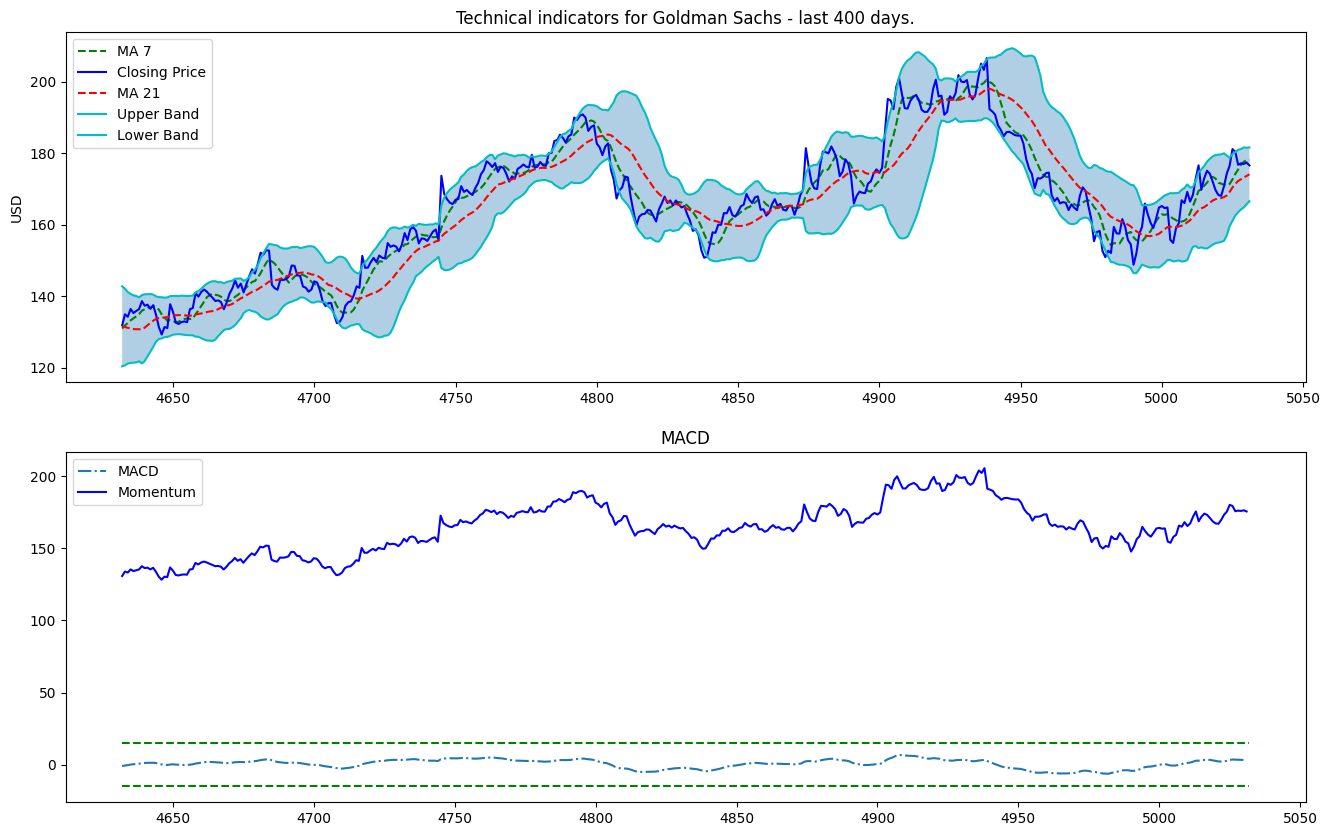

In [17]:
plot_technical_indicators(dataset_TI_df, 400)

In [18]:
for column in dataset_TI_df.columns:
    if column not in ['Date', 'Close']:
      total_df[column] = dataset_TI_df[column]

In [19]:
data_FT = df[['Date', 'Close']]

In [20]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

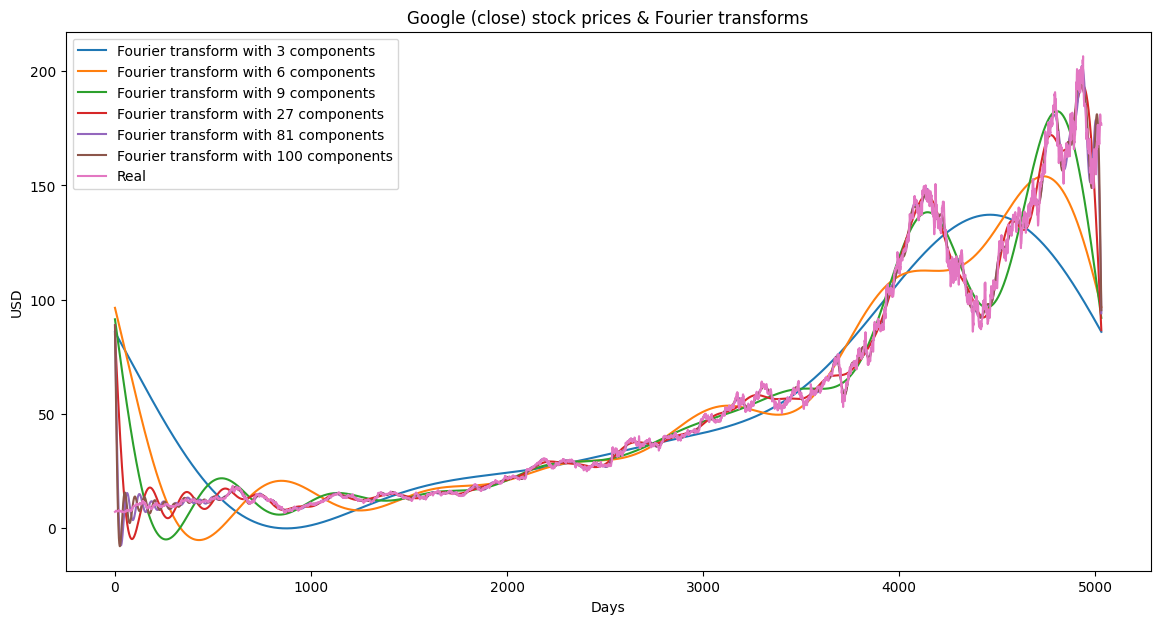

In [21]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9,27,81, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Google (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [22]:
components_list = [3, 6, 9,27, 81, 100]
for num_ in components_list:
  fft_list = np.asarray(fft_df['fft'].tolist())
  fft_list_filtered = np.copy(fft_list)
  fft_list_filtered[num_:-num_] = 0
  ifft_values = np.fft.ifft(fft_list_filtered).real

  total_df[f'fourier_{num_}'] = ifft_values

In [23]:
import statsmodels.api as sm
from pandas import DataFrame

series = data_FT['Close']
model = sm.tsa.arima.ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5032
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8135.550
Date:                Thu, 26 Jun 2025   AIC                          16283.100
Time:                        16:28:38   BIC                          16322.241
Sample:                             0   HQIC                         16296.814
                               - 5032                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0642      0.006     10.555      0.000       0.052       0.076
ar.L2         -0.0242      0.008     -3.133      0.002      -0.039      -0.009
ar.L3         -0.0504      0.008     -6.666      0.0

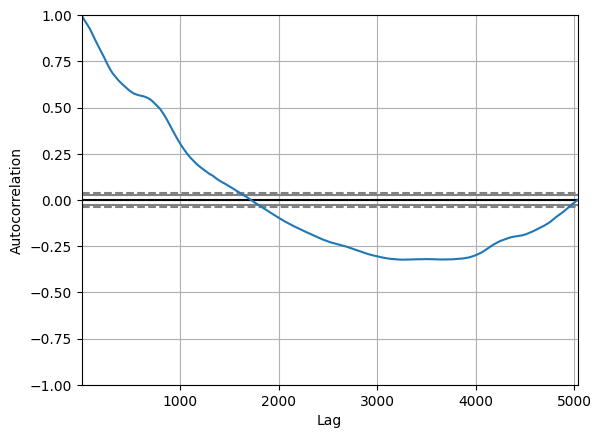

<Figure size 800x560 with 0 Axes>

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [25]:
from pandas import read_csv
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [26]:
total_df['arima_pred'] = np.nan

total_df.iloc[size:size+len(predictions), total_df.columns.get_loc('arima_pred')] = predictions

In [27]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 4.180


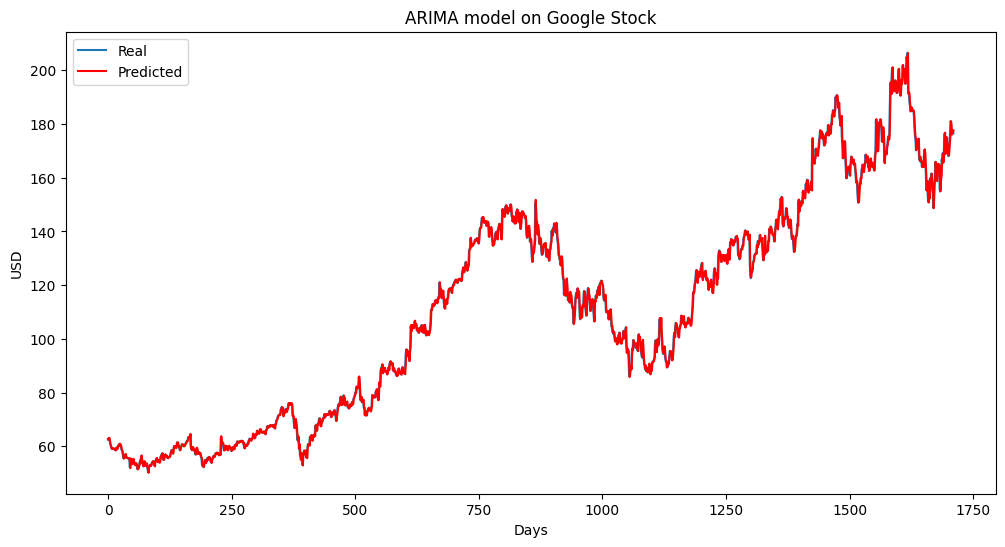

In [28]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on Google Stock')
plt.legend()
plt.show()

In [29]:
total_df

,Date,Close,pct_change,log_change,Price,High,Low,Open,7ma,14ma,...,lower_band,ema,momentum,fourier_3,fourier_6,fourier_9,fourier_27,fourier_81,fourier_100,arima_pred
0,2005-06-20,7.156032,NaN,NaN,7.131903,6.759511,6.867970,840147012,7.156032,7.156032,...,NaN,7.156032,6.156032,85.787221,96.437706,91.413979,84.811759,88.744291,88.864397,NaN
1,2005-06-21,7.221455,0.009142,0.009101,7.160260,7.088866,7.165982,604686708,7.172388,7.164755,...,NaN,7.205099,6.221455,85.632584,96.086103,90.779104,82.983296,83.440451,82.318455,NaN
2,2005-06-22,7.271704,0.006958,0.006934,7.196579,7.180908,7.205783,418541040,7.197217,7.179015,...,NaN,7.251210,6.271704,85.477867,95.734017,90.144344,81.159640,78.150293,75.801598,NaN
3,2005-06-23,7.333646,0.008518,0.008482,7.206779,7.126928,7.164241,561693744,7.231324,7.199632,...,NaN,7.306854,6.333646,85.323070,95.381455,89.509730,79.341496,72.893028,69.348796,NaN
4,2005-06-24,7.412999,0.010820,0.010762,7.394343,7.203545,7.236381,710137152,7.276743,7.228081,...,NaN,7.377910,6.412999,85.168194,95.028426,88.875294,77.529566,67.687584,62.994321,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,2025-06-12,176.720001,-0.020236,-0.020444,175.699997,174.750000,176.179993,20941900,176.265101,173.876052,...,163.428982,177.802211,175.720001,86.559161,98.188186,94.588954,94.001190,114.791864,120.798643,179.844426
5028,2025-06-13,177.130005,0.002320,0.002317,174.669998,172.389999,172.440002,27663100,176.481327,174.309912,...,164.236585,177.354074,176.130005,86.404941,97.839122,93.953985,92.159412,109.709158,114.633414,176.076923
5029,2025-06-16,176.940002,-0.001073,-0.001073,176.770004,174.649994,174.729996,27389200,176.595996,174.660591,...,164.787954,177.078026,175.940002,86.250637,97.489534,93.318971,90.318860,104.544100,108.323384,176.943835
5030,2025-06-17,177.360001,0.002374,0.002371,175.949997,174.580002,175.699997,24973000,176.786997,175.020512,...,165.677991,177.266009,176.360001,86.096248,97.139430,92.683944,88.480255,99.315486,101.902109,177.100034


In [30]:
dataset_TI_df = dataset_TI_df.fillna(method='bfill').fillna(method='ffill')

In [31]:
total_df = total_df.fillna(method='bfill').fillna(method='ffill')

In [32]:
print('Total dataset has {} samples, and {} features.'.format(total_df.shape[0], \
                                                              total_df.shape[1]))

Total dataset has 5032 samples, and 46 features.


In [33]:
total_df.set_index('Date')

,Close,pct_change,log_change,Price,High,Low,Open,7ma,14ma,21ma,...,lower_band,ema,momentum,fourier_3,fourier_6,fourier_9,fourier_27,fourier_81,fourier_100,arima_pred
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-20,7.156032,0.009142,0.009101,7.131903,6.759511,6.867970,840147012,7.156032,7.156032,7.156032,...,7.160677,7.156032,6.156032,85.787221,96.437706,91.413979,84.811759,88.744291,88.864397,62.663655
2005-06-21,7.221455,0.009142,0.009101,7.160260,7.088866,7.165982,604686708,7.172388,7.164755,7.161979,...,7.160677,7.205099,6.221455,85.632584,96.086103,90.779104,82.983296,83.440451,82.318455,62.663655
2005-06-22,7.271704,0.006958,0.006934,7.196579,7.180908,7.205783,418541040,7.197217,7.179015,7.171954,...,7.160677,7.251210,6.271704,85.477867,95.734017,90.144344,81.159640,78.150293,75.801598,62.663655
2005-06-23,7.333646,0.008518,0.008482,7.206779,7.126928,7.164241,561693744,7.231324,7.199632,7.186654,...,7.160677,7.306854,6.333646,85.323070,95.381455,89.509730,79.341496,72.893028,69.348796,62.663655
2005-06-24,7.412999,0.010820,0.010762,7.394343,7.203545,7.236381,710137152,7.276743,7.228081,7.207230,...,7.160677,7.377910,6.412999,85.168194,95.028426,88.875294,77.529566,67.687584,62.994321,62.663655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,176.720001,-0.020236,-0.020444,175.699997,174.750000,176.179993,20941900,176.265101,173.876052,171.993568,...,163.428982,177.802211,175.720001,86.559161,98.188186,94.588954,94.001190,114.791864,120.798643,179.844426
2025-06-13,177.130005,0.002320,0.002317,174.669998,172.389999,172.440002,27663100,176.481327,174.309912,172.460516,...,164.236585,177.354074,176.130005,86.404941,97.839122,93.953985,92.159412,109.709158,114.633414,176.076923
2025-06-16,176.940002,-0.001073,-0.001073,176.770004,174.649994,174.729996,27389200,176.595996,174.660591,172.867742,...,164.787954,177.078026,175.940002,86.250637,97.489534,93.318971,90.318860,104.544100,108.323384,176.943835


In [34]:
total_df.to_csv('GOOGL_20y_Final_Data.csv')